In [31]:
# previous pos lenght = 423

In [32]:
import pandas as pd
import numpy as np
import pyswarms as ps

df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')
df.head(2)

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0


In [33]:
X = df.copy()
y = X.HeartDiseaseorAttack
X.drop(columns="HeartDiseaseorAttack",inplace=True)
X.shape,y.shape

((253680, 21), (253680,))

In [34]:
from sklearn.model_selection import StratifiedKFold, train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((177576, 21), (76104, 21), (177576,), (76104,))

In [35]:
X_train = X_train.values
y_train = y_train.values
X_train.shape,y_train.shape

((177576, 21), (177576,))

# Particles Swarm Optimization

In [36]:
n_inputs = X_train.shape[1]
n_hidden = 20
n_classes = 2
num_samples = len(X_train)
# iteration = 1000
iteration = 20

In [37]:
a = n_inputs*n_hidden
b = a+n_hidden
c = b+(n_hidden*n_classes)
d = c+n_classes

In [38]:
def logits_function(p):
    """ Calculate roll-back the weights and biases

    Inputs
    ------
    p: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    numpy.ndarray of logits for layer 2

    """
    # Roll-back the weights and biases
    W1 = p[0:a].reshape((n_inputs,n_hidden))
    b1 = p[a:b].reshape((n_hidden,))
    W2 = p[b:c].reshape((n_hidden,n_classes))
    b2 = p[c:d].reshape((n_classes,))

    # Perform forward propagation
    z1 = X_train.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1
    logits = a1.dot(W2) + b2 # Pre-activation in Layer 2
    return logits          # Logits for Layer 2


In [39]:
# Forward propagation
def forward_prop(params):
    """Forward propagation as objective function

    This computes for the forward propagation of the neural network, as
    well as the loss.

    Inputs
    ------
    params: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    float
        The computed negative log-likelihood loss given the parameters
    """

    logits = logits_function(params)

    # Compute for the softmax of the logits
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute for the negative log likelihood

    corect_logprobs = -np.log(probs[range(num_samples), y_train])
    print(corect_logprobs)
    loss = np.sum(corect_logprobs) / num_samples

    return loss

In [40]:
def f(x):
    """Higher-level method to do forward_prop in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    return np.array(j)

In [41]:
%%time
# Initialize swarm
options = {'c1': 0.8, 'c2': 0.6, 'w':0.9}

# Call instance of PSO
dimensions = (n_inputs * n_hidden) + (n_hidden * n_classes) + n_hidden + n_classes
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=iteration)

2024-10-08 11:23:20,344 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.8, 'c2': 0.6, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/20

pyswarms.single.global_best:   0%|          |0/20


IndexError: arrays used as indices must be of integer (or boolean) type

In [42]:
def predict(pos):
    """
    Use the trained weights to perform class predictions.

    Inputs
    ------
    pos: numpy.ndarray
        Position matrix found by the swarm. Will be rolled
        into weights and biases.
    """
    logits = logits_function(pos)
    y_pred = np.argmax(logits, axis=1)
    return y_pred

In [43]:
(predict(pos) == y_train).mean()

NameError: name 'pos' is not defined

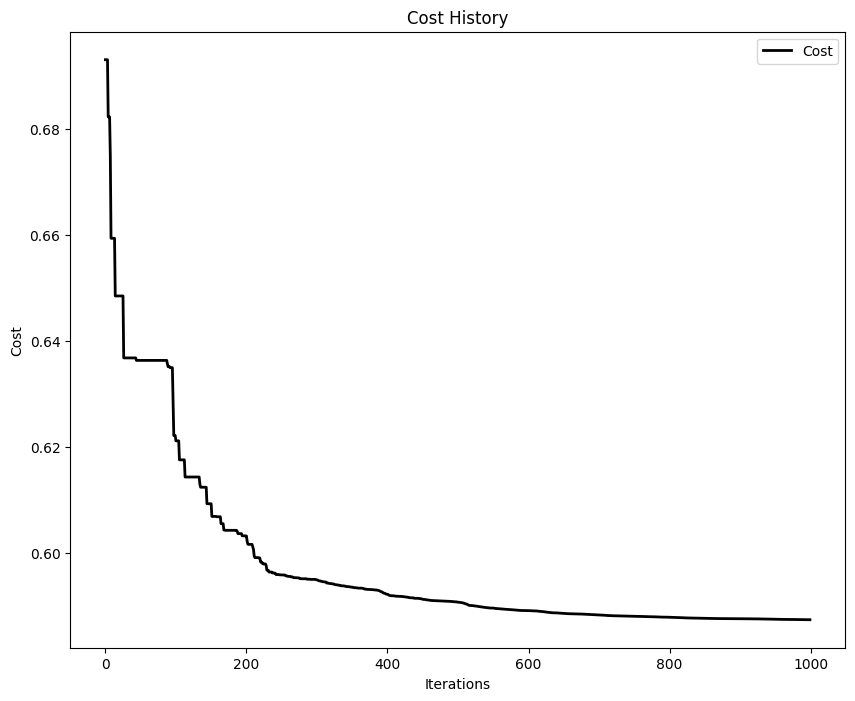

In [19]:
from pyswarms.utils.plotters.formatters import Mesher
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import matplotlib.pyplot as plt
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

In [21]:
optimizer.cost_history[-1]

np.float64(0.5874931325147155)